Train data shape: (150000, 31)
TestA data shape: (50000, 30)
        SaleID    name   regDate  model  brand  bodyType  fuelType  gearbox  \
0            0     736  20040402   30.0      6       1.0       0.0      0.0   
1            1    2262  20030301   40.0      1       2.0       0.0      0.0   
2            2   14874  20040403  115.0     15       1.0       0.0      0.0   
149997  149997  147587  20101003   60.0     11       1.0       1.0      0.0   
149998  149998   45907  20060312   34.0     10       3.0       1.0      0.0   
149999  149999  177672  19990204   19.0     28       6.0       0.0      1.0   

        power  kilometer  ...       v_5       v_6       v_7       v_8  \
0          60       12.5  ...  0.235676  0.101988  0.129549  0.022816   
1           0       15.0  ...  0.264777  0.121004  0.135731  0.026597   
2         163       12.5  ...  0.251410  0.114912  0.165147  0.062173   
149997     90        6.0  ...  0.233353  0.000705  0.118872  0.100118   
149998    156       

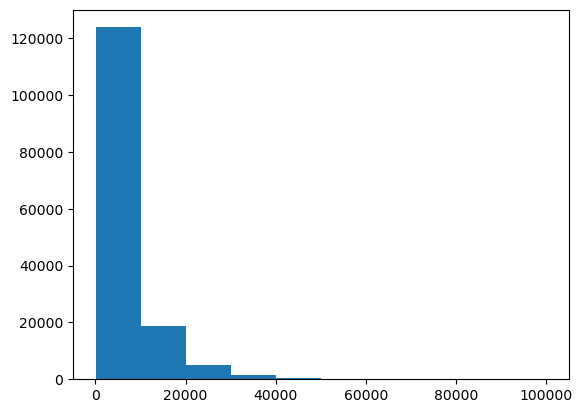

Train mae: 622.836567743063
Val mae 714.5103914234173
Train lgb...
MAE of val with lgb: 687.063082548043
Predict lgb...
Sta of Predict lgb:
_min -589.8793550785414
_max: 90760.26063584947
_mean 5906.935218383807
_ptp 91350.13999092802
_std 7344.644970956768
_var 53943809.749400534
Train xgb...
MAE of val with xgb: 711.1309352078543
Predict xgb...
Sta of Predict xgb:
_min -130.30826
_max: 90538.914
_mean 5910.402
_ptp 90669.22
_std 7344.5894
_var 53942990.0
MAE of val with Weighted ensemble: 683.6130430466491


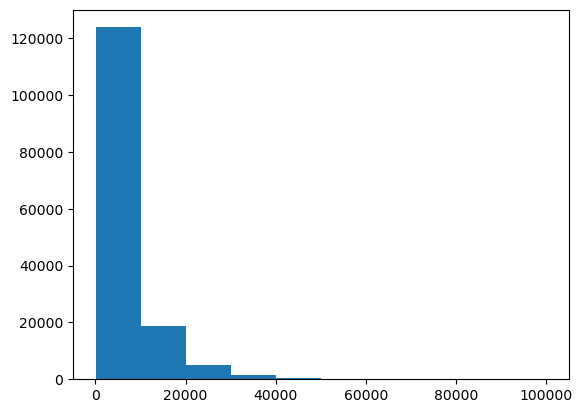

       SaleID         price
0           0   1161.931753
1           1   1792.844377
2           2   8577.098288
3           3   1337.183849
4           4   2066.307967
...       ...           ...
49995   49995   5842.504555
49996   49996  19056.950721
49997   49997   5449.086001
49998   49998   5647.550550
49999   49999   5371.980360

[50000 rows x 2 columns]


In [4]:
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time 
warnings.filterwarnings('ignore')
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
# 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
# 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA
import lightgbm as lgb
import xgboost as xgb
## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 通过Pandas对于数据进行读取 
Train_data = pd.read_csv(r'D:/Dataming/used_car_train_20200313/used_car_train_20200313.csv',sep=' ')
TestB_data = pd.read_csv(r'D:/Dataming/used_car_testB_20200421/used_car_testB_20200421.csv', sep=' ')
# 输出数据的大小信息
print('Train data shape:',Train_data.shape)
print('TestA data shape:',TestB_data.shape)
# 通过.head() 简要浏览读取数据的形式
# 前面三条数据+后面三条数据
print(Train_data.head(3).append(Train_data.tail(3)))
#通过 .info() 简要可以看到对应一些数据列名，以及NAN缺失信息
print(Train_data.info())
#通过 .columns 查看列名
print(Train_data.columns)
#查看每列缺失值
print(TestA_data.info())
#通过 .describe() 可以查看数值特征列的一些统计信息
print(Train_data.describe())
print(TestA_data.describe())
#提取数值类型特征列名
numerical_cols=Train_data.select_dtypes(exclude='object').columns
print(numerical_cols)
#选择特征列
feature_cols = [col for col in numerical_cols if col not in ['SaleID','name','regDate','creatDate','price','model','brand','regionCode','seller']]
feature_cols = [col for col in feature_cols if 'Type' not in col]
#提前特征列，标签列构造训练样本和测试样本
X_data = Train_data[feature_cols]
Y_data = Train_data['price']
X_test  = TestA_data[feature_cols]
print('X train shape:',X_data.shape)
print('X test shape:',X_test.shape)
#定义一个统计函数，方便后续信息统计
def Sta_inf(data):
    print('_min',np.min(data))
    print('_max:',np.max(data))
    print('_mean',np.mean(data))
    print('_ptp',np.ptp(data))
    print('_std',np.std(data))
    print('_var',np.var(data))
#查看标签信息
print('Sta of label:')
Sta_inf(Y_data)
#绘制标签的统计图，查看标签分布
plt.hist(Y_data)
plt.show()
plt.close()
#缺失值用-1填充
X_data = X_data.fillna(-1)
X_test = X_test.fillna(-1)
# xgb-Model
xgr = xgb.XGBRegressor(n_estimators=120, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #,objective ='reg:squarederror'
scores_train = []
scores = []
#5折交叉验证方式
sk=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
for train_ind,val_ind in sk.split(X_data,Y_data):
    train_x=X_data.iloc[train_ind].values
    train_y=Y_data.iloc[train_ind]
    val_x=X_data.iloc[val_ind].values
    val_y=Y_data.iloc[val_ind]
   
    xgr.fit(train_x,train_y)
    pred_train_xgb=xgr.predict(train_x)
    pred_xgb=xgr.predict(val_x)
   
    score_train = mean_absolute_error(train_y,pred_train_xgb)
    scores_train.append(score_train)
    score = mean_absolute_error(val_y,pred_xgb)
    scores.append(score)
print('Train mae:',np.mean(score_train))
print('Val mae',np.mean(scores))
#定义xgb和lgb模型函数
def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=150, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #, objective ='reg:squarederror'
    model.fit(x_train, y_train)
    return model
def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=127,n_estimators = 150)
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
    }
    gbm = GridSearchCV(estimator, param_grid)
    gbm.fit(x_train, y_train)
    return gbm
#切分数据集（Train,Val）进行模型训练，评价和预测
# Split data with val
x_train,x_val,y_train,y_val = train_test_split(X_data,Y_data,test_size=0.3)
print('Train lgb...')
model_lgb = build_model_lgb(x_train,y_train)
val_lgb = model_lgb.predict(x_val)
MAE_lgb = mean_absolute_error(y_val,val_lgb)
print('MAE of val with lgb:',MAE_lgb)
print('Predict lgb...')
model_lgb_pre = build_model_lgb(X_data,Y_data)
subA_lgb = model_lgb_pre.predict(X_test)
print('Sta of Predict lgb:')
Sta_inf(subA_lgb)
print('Train xgb...')
model_xgb = build_model_xgb(x_train,y_train)
val_xgb = model_xgb.predict(x_val)
MAE_xgb = mean_absolute_error(y_val,val_xgb)
print('MAE of val with xgb:',MAE_xgb)
print('Predict xgb...')
model_xgb_pre = build_model_xgb(X_data,Y_data)
subA_xgb = model_xgb_pre.predict(X_test)
print('Sta of Predict xgb:')
Sta_inf(subA_xgb)
#这里我们采取了简单的加权融合的方式
val_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*val_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*val_xgb
val_Weighted[val_Weighted<0]=10 
#由于我们发现预测的最小值有负数，而真实情况下，price为负是不存在的，由此我们进行对应的后修正
print('MAE of val with Weighted ensemble:',mean_absolute_error(y_val,val_Weighted))
#进行两模型的结果加权融合
sub_Weighted= (1-MAE_lgb/(MAE_xgb+MAE_lgb))*subA_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*subA_xgb
## 查看预测值的统计进行
plt.hist(Y_data)
plt.show()
plt.close()
#输出结果
sub = pd.DataFrame()
sub['SaleID'] = X_test.index
sub['price'] = sub_Weighted
sub.to_csv('./sub_Weighted.csv',index=False)
print(sub)
